<a href="https://colab.research.google.com/github/OBVillasis/AMSI2026_DataScienceandAI_Project/blob/main/Acne_CNN_on_STL10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STL10 Classification Using CNN
## Goal:
Build a deep learning model to classify STL10 types using a CNN model, while addressing dataset imbalance through oversampling and augmentation.

## ----------------------------
## 1. IMPORTS
## ----------------------------

In [3]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## 📦 2. Load **STL-10** Dataset (TensorFlow Datasets)

We reuse the **same CNN code style** from the acne notebook, but swap the dataset to **STL-10 (10 classes, 96×96 RGB)**.

- Train split: `train[:80%]`
- Validation split: `train[80%:]`
- Test split: `test`


In [4]:

import tensorflow_datasets as tfds

# ----------------------------
# PARAMETERS (adjust if needed)
# ----------------------------
BATCH_SIZE = 32
IMAGE_SIZE = 96  # STL-10 native size is 96x96

# ----------------------------
# LOAD DATA
# ----------------------------
(train_raw, val_raw, test_raw), ds_info = tfds.load(
    "stl10",
    split=["train[:80%]", "train[80%:]", "test"],
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features["label"].names
NUM_CLASSES = ds_info.features["label"].num_classes

print("Classes:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)
print("Train:", tf.data.experimental.cardinality(train_raw).numpy())
print("Val:", tf.data.experimental.cardinality(val_raw).numpy())
print("Test:", tf.data.experimental.cardinality(test_raw).numpy())


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.FNR0GJ_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.FNR0GJ_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.FNR0GJ_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
NUM_CLASSES: 10
Train: 4000
Val: 1000
Test: 8000


## 🖼️ 3. Visualize Sample Images (STL-10)

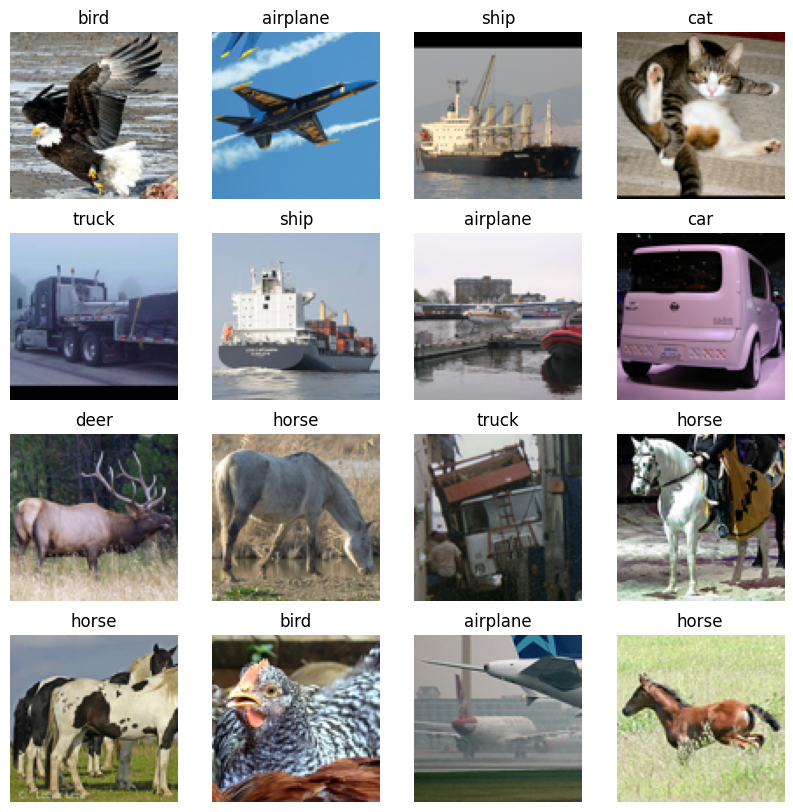

In [7]:

import matplotlib.pyplot as plt

for images, labels in train_raw.batch(16).take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    plt.show()


## 🔧 4. Preprocessing, Normalization, Augmentation

In [8]:

# Reuse the same augmentation pattern as the acne notebook
normalization_layer = Rescaling(1./255)

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),
    RandomZoom(0.10),
])

def preprocess_train(x, y):
    # Ensure size is consistent (STL10 is already 96x96, but kept for safety)
    x = tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = data_augmentation(x, training=True)
    x = normalization_layer(x)
    return x, y

def preprocess_eval(x, y):
    x = tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = normalization_layer(x)
    return x, y

train_ds = (train_raw
            .shuffle(5000)
            .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

valid_ds = (val_raw
            .map(preprocess_eval, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_raw
           .map(preprocess_eval, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))


## 🧰 5. Build CNN Model

In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,186 (2.18 MB)

 Trainable params: 570,186 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️‍♂️ 6. Train Model


In [ ]:
# ----------------------------
# CALLBACKS
# ----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ----------------------------
# TRAIN MODEL
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

Epoch 1/50
125/125 - 82s - 652ms/step - accuracy: 0.1200 - loss: 2.3769 - val_accuracy: 0.1550 - val_loss: 2.2739 - learning_rate: 1.0000e-03
Epoch 2/50
125/125 - 79s - 632ms/step - accuracy: 0.1790 - loss: 2.1415 - val_accuracy: 0.2480 - val_loss: 1.9281 - learning_rate: 1.0000e-03
Epoch 3/50
125/125 - 81s - 646ms/step - accuracy: 0.2582 - loss: 1.9262 - val_accuracy: 0.2700 - val_loss: 1.9008 - learning_rate: 1.0000e-03
Epoch 4/50
125/125 - 92s - 736ms/step - accuracy: 0.2795 - loss: 1.8099 - val_accuracy: 0.3050 - val_loss: 1.7287 - learning_rate: 1.0000e-03
Epoch 5/50
125/125 - 90s - 718ms/step - accuracy: 0.3115 - loss: 1.7479 - val_accuracy: 0.3430 - val_loss: 1.6424 - learning_rate: 1.0000e-03
Epoch 6/50
125/125 - 131s - 1s/step - accuracy: 0.3530 - loss: 1.6871 - val_accuracy: 0.3320 - val_loss: 1.6309 - learning_rate: 1.0000e-03
Epoch 7/50
125/125 - 78s - 628ms/step - accuracy: 0.3692 - loss: 1.6488 - val_accuracy: 0.3490 - val_loss: 1.6289 - learning_rate: 1.0000e-03
Epoch 8/

## 📈 7. Evaluate Model

In [7]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.5790 - loss: 1.1836
Test Accuracy: 0.5903750061988831


## 🔍 8. Confusion Matrix & Classification Report

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true and predicted labels for test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

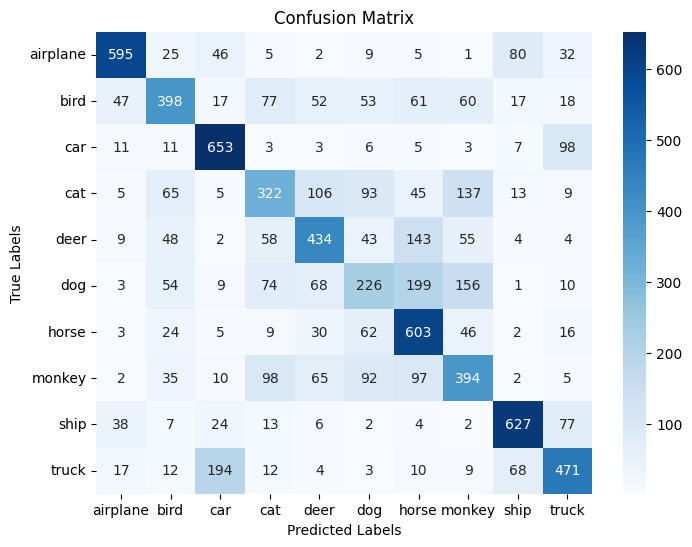

In [9]:
# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



In [10]:
# ----------------------------
# CLASSIFICATION REPORT
# ----------------------------
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

    airplane       0.82      0.74      0.78       800
        bird       0.59      0.50      0.54       800
         car       0.68      0.82      0.74       800
         cat       0.48      0.40      0.44       800
        deer       0.56      0.54      0.55       800
         dog       0.38      0.28      0.33       800
       horse       0.51      0.75      0.61       800
      monkey       0.46      0.49      0.47       800
        ship       0.76      0.78      0.77       800
       truck       0.64      0.59      0.61       800

    accuracy                           0.59      8000
   macro avg       0.59      0.59      0.58      8000
weighted avg       0.59      0.59      0.58      8000



## 📊 9. Accuracy and Loss Curves


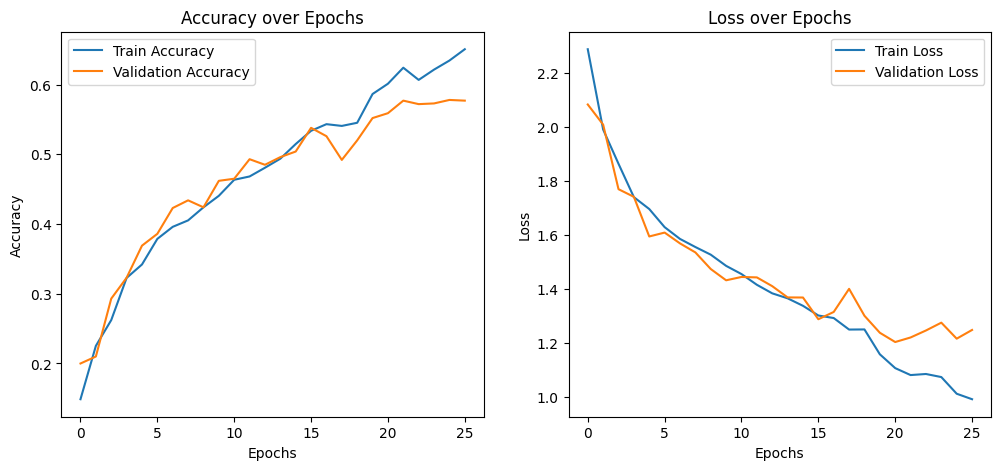

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()